In [33]:
import pandas as pd
import numpy as np
import os
import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

In [18]:
df = pd.read_csv("balanced-all.csv")
df.head()

,filename,gender
0,data/cv-other-train/sample-069205.npy,female
1,data/cv-valid-train/sample-063134.npy,female
2,data/cv-other-train/sample-080873.npy,female
3,data/cv-other-train/sample-105595.npy,female
4,data/cv-valid-train/sample-144613.npy,female


In [19]:
# get total samples
n_samples = len(df)
# get total male samples
n_male_samples = len(df[df['gender'] == 'male'])
# get total female samples
n_female_samples = len(df[df['gender'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)

Total samples: 66938
Total male samples: 33469
Total female samples: 33469


In [21]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("balanced-all.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [22]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [23]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [28]:
def create_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [29]:
# construct the model
model = create_model()

c:\Users\Sanjay\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,545 (611.50 KB)

 Trainable params: 156,545 (611.50 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 25
# train the model using the training set and validating using validation set
history=model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8964 - loss: 0.2742 - val_accuracy: 0.9109 - val_loss: 0.2355
Epoch 2/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9012 - loss: 0.2657 - val_accuracy: 0.9135 - val_loss: 0.2358
Epoch 3/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9008 - loss: 0.2674 - val_accuracy: 0.9165 - val_loss: 0.2308
Epoch 4/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9005 - loss: 0.2676 - val_accuracy: 0.9125 - val_loss: 0.2320
Epoch 5/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8993 - loss: 0.2707 - val_accuracy: 0.8989 - val_loss: 0.2461
Epoch 6/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8980 - loss: 0.2706 - val_accuracy: 0.9150 - val_loss: 0.2264
Epoch 7/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9001 - loss: 0.2673 - val_accuracy: 0.9107 - val_loss: 0.2376
Epoch 8/25
848/848 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9027 - loss: 0.2589 - 

In [36]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 6694 samples...
Loss: 0.2321
Accuracy: 91.47%


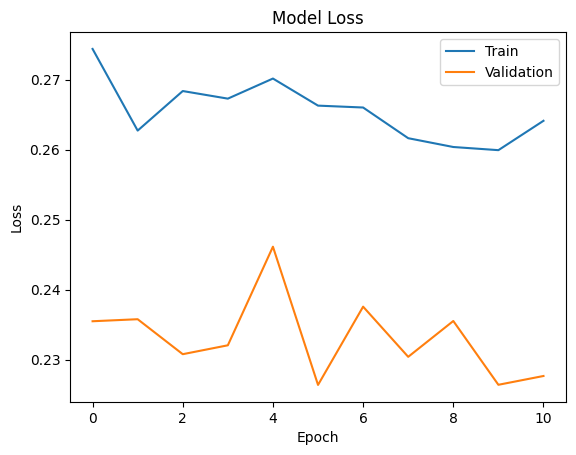

In [38]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [39]:
import librosa
import numpy as np

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [40]:
# Save model and weights
model_name = 'Gender_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\Sanjay\Desktop\task1\saved_models\Gender_Model.h5 
